# RNN Example for Time Series

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [2]:
df = pd.read_csv('RSCCASN.csv',index_col='DATE',parse_dates=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [4]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [5]:
df.columns = ['Sales']

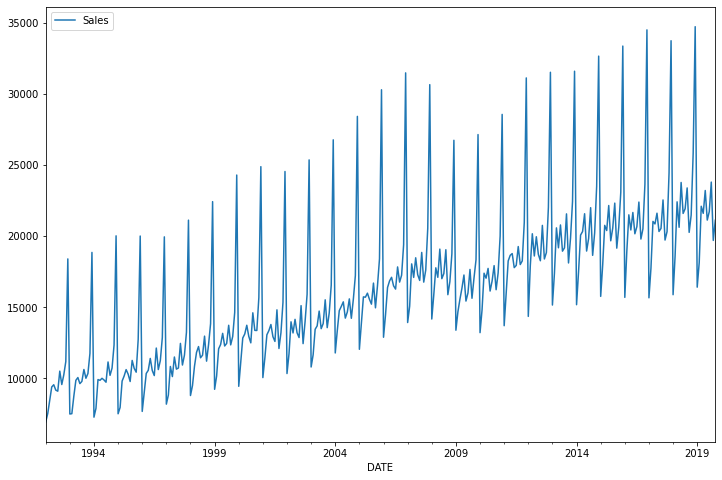

In [6]:
df.plot(figsize=(12,8))
plt.show()

## Train Test Split

In [7]:
len(df)

334

Data is monthly, let's forecast 1.5 years into the future.

In [8]:
test_size = 18

In [9]:
test_ind = len(df)- test_size

In [10]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [11]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [12]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


## Scale Data

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [16]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [17]:
scaled_train.max()

1.0

# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [18]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [19]:
# Let's redefine to get 12 months back and then predict the next month out
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

In [20]:
# What does the first batch look like?
X,y = generator[0]

In [21]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


### Create the Model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [23]:
# We're only using one feature in our time series
n_features = 1

In [24]:
# define model
model = Sequential()

# LSTM layer
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))

# Final Prediction
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and creating a Validation Generator

NOTE: The scaled_test dataset size MUST be greater than your length chosen for your batches. Review video for more info on this.

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

In [27]:
# patience = 2, cause there is too much noise
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [28]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)

In [29]:
# fit model
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


304/304 [==============================] - 3s 6ms/step - loss: 0.0257 - val_loss: 0.0410
Epoch 2/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0168 - val_loss: 0.0026
Epoch 3/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0097 - val_loss: 9.2179e-04
Epoch 4/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0045 - val_loss: 0.0052
Epoch 5/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0067 - val_loss: 0.0036


In [30]:
losses = pd.DataFrame(model.history.history)

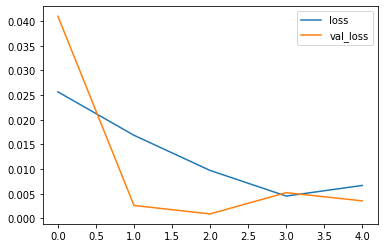

In [31]:
losses.plot()
plt.show()

## Evaluate on Test Data

In [32]:
first_eval_batch = scaled_train[-length:]

In [34]:
first_eval_batch

array([[0.53252977],
       [0.48591345],
       [0.49364653],
       [0.56629393],
       [0.46405751],
       [0.48536886],
       [0.63534708],
       [0.97233517],
       [0.32468051],
       [0.42285071],
       [0.5615016 ],
       [0.49658728]])

In [35]:
# prediction list
test_predictions = []

first_eval_batch = scaled_train[-length:]

# update variable
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

## Inverse Transformations and Compare

In [36]:
true_predictions = scaler.inverse_transform(test_predictions)

In [37]:
# IGNORE WARNINGS
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [39]:
test.head()

,Sales,Predictions
DATE,,
2018-05-01,23764,22597.628716
2018-06-01,21589,21708.202263
2018-07-01,21919,21918.989872
2018-08-01,23381,23384.339060
2018-09-01,20260,21435.929462


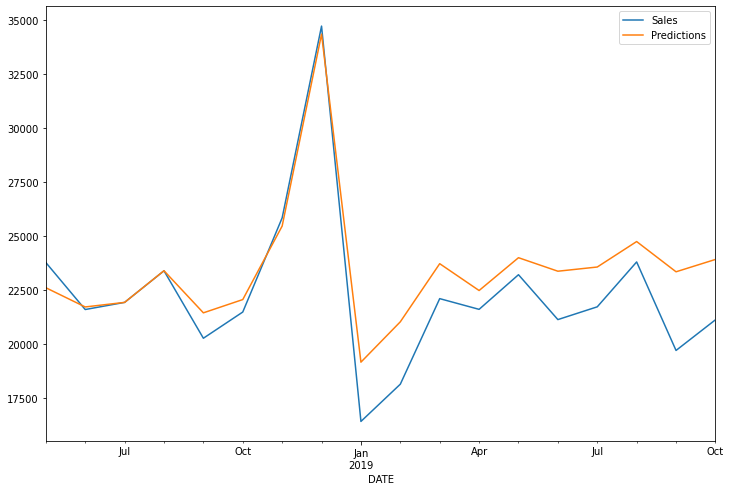

In [40]:
test.plot(figsize=(12,8))
plt.show()

# Retrain and Forecasting

In [41]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [42]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=1)

In [43]:
# new forecaste model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [45]:
# fit model
model.fit_generator(generator,epochs=5)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
322/322 [==============================] - 3s 5ms/step - loss: 0.0255
Epoch 2/5
322/322 [==============================] - 2s 5ms/step - loss: 0.0183
Epoch 3/5
322/322 [==============================] - 2s 5ms/step - loss: 0.0122
Epoch 4/5
322/322 [==============================] - 2s 5ms/step - loss: 0.0063
Epoch 5/5
322/322 [==============================] - 2s 5ms/step - loss: 0.0033


In [46]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [47]:
forecast = scaler.inverse_transform(forecast)

### Creating new timestamp index with pandas.

In [48]:
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [49]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [50]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [52]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index,
                           columns=['Forecast'])

In [53]:
forecast_df

,Forecast
2019-11-01,26016.325886
2019-12-01,36532.792432
2020-01-01,16231.622763
2020-02-01,18097.264338
2020-03-01,21610.605131
2020-04-01,21319.013854
2020-05-01,22821.356602
2020-06-01,20998.690304
2020-07-01,21617.157357
2020-08-01,23535.634562


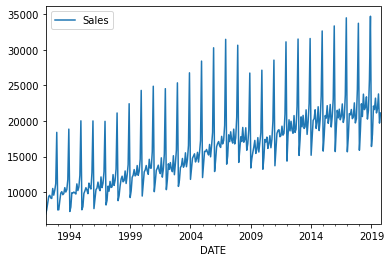

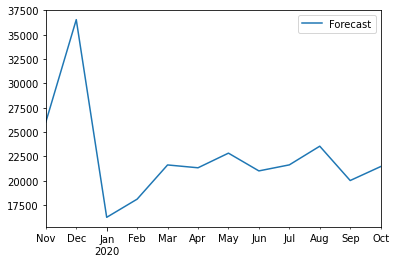

In [56]:
df.plot()
forecast_df.plot()
plt.show()

### Joining pandas plots

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

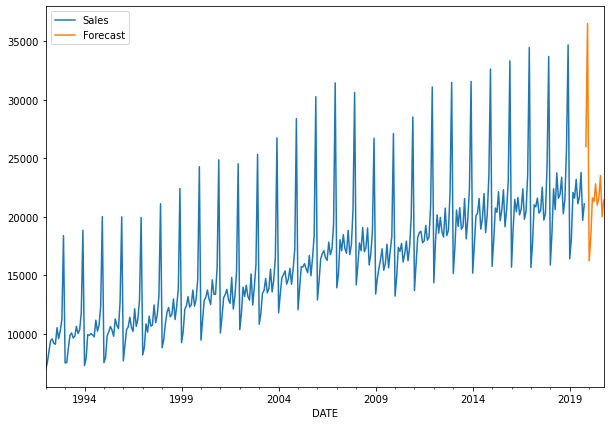

In [58]:
ax = df.plot(figsize=(10,7))
forecast_df.plot(ax=ax)
plt.show()

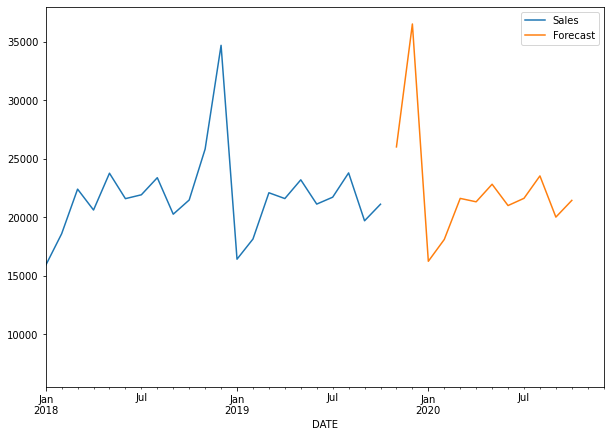

In [59]:
# xlim
ax = df.plot(figsize=(10,7))
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')
plt.show()

In [60]:
model.save('retail_sales_model.h5')